In [1]:
import numpy as np
import pandas as pd

from keras.models import Sequential
from keras.applications import MobileNetV2
from keras.layers import Dense, GlobalAveragePooling2D
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from keras import backend as K
from keras.utils.vis_utils import plot_model
from keras.optimizers import Adam

import matplotlib.pyplot as plt
plt.style.use('seaborn-ticks')
import cv2

Using TensorFlow backend.


In [2]:
image_size = (96, 96, 3)

datagen = ImageDataGenerator(
    rotation_range=25, width_shift_range=0.1, height_shift_range=0.1,  fill_mode="nearest",
    rescale = 1./255, shear_range = 0.2, zoom_range = 0.2, horizontal_flip = True, validation_split=0.05,
)

In [3]:
training_set = datagen.flow_from_directory(
    '../gender_dataset/', target_size = image_size[:2],  batch_size = 32, class_mode = 'binary', subset='training', 
    color_mode='rgb'
)

Found 2193 images belonging to 2 classes.


In [4]:
validation_set = datagen.flow_from_directory(
    '../gender_dataset/',  target_size = image_size[:2], batch_size = 32, class_mode = 'binary', subset='validation', 
    color_mode='rgb'
)

Found 114 images belonging to 2 classes.


In [5]:
training_set.class_indices

{'man': 0, 'woman': 1}

In [6]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
filepath = "gender_mobilenet.h5"
ckpt = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
rlp = ReduceLROnPlateau(monitor='loss', patience=3, factor=0.2)

opt = Adam(lr=0.001, decay=0.000001)

In [8]:
base_model = MobileNetV2(input_shape=image_size, include_top=False, weights='imagenet')
base_model.trainable = True

base_model.summary()

global_average_layer = GlobalAveragePooling2D()

prediction_layer = Dense(1, activation = 'sigmoid')

Model: "mobilenetv2_1.00_96"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 96, 96, 3)    0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 97, 97, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 48, 48, 32)   864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 48, 48, 32)   128         Conv1[0][0]                      
________________________________________________________________________________

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_96 (Model)  (None, 3, 3, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1280)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 1281      
Total params: 2,259,265
Trainable params: 2,225,153
Non-trainable params: 34,112
_________________________________________________________________


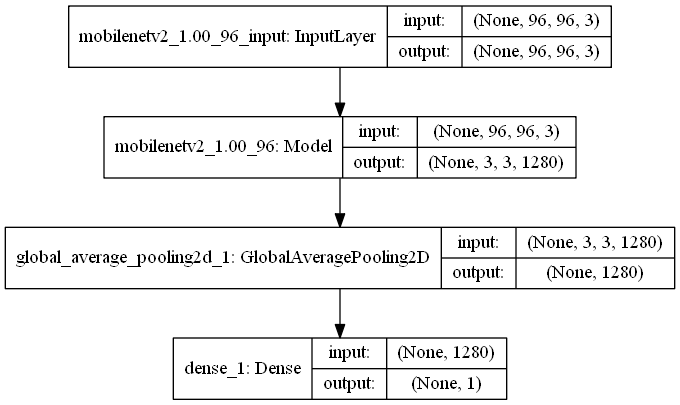

In [9]:
neuralnetwork = Sequential([
  base_model,
  global_average_layer,
  prediction_layer
])

neuralnetwork.compile(optimizer=opt, loss='binary_crossentropy', metrics = ['acc'])

neuralnetwork.summary()

plot_model(neuralnetwork, to_file="gender_mobilenet.png", show_shapes=True)

In [10]:
history = neuralnetwork.fit_generator(
    training_set,
    validation_data = validation_set,
    callbacks=[es, ckpt, rlp], epochs = 1000, 
)

Epoch 1/1000
69/69 [==============================] - 213s 3s/step - loss: 0.3388 - acc: 0.8700 - val_loss: 5.2272 - val_acc: 0.5000

Epoch 00001: loss improved from inf to 0.34053, saving model to gender_mobilenet.h5
Epoch 2/1000
69/69 [==============================] - 142s 2s/step - loss: 0.1376 - acc: 0.9485 - val_loss: 10.6930 - val_acc: 0.5088

Epoch 00002: loss improved from 0.34053 to 0.13772, saving model to gender_mobilenet.h5
Epoch 3/1000
69/69 [==============================] - 130s 2s/step - loss: 0.1039 - acc: 0.9617 - val_loss: 15.3159 - val_acc: 0.4912

Epoch 00003: loss improved from 0.13772 to 0.10444, saving model to gender_mobilenet.h5
Epoch 4/1000
69/69 [==============================] - 129s 2s/step - loss: 0.0987 - acc: 0.9631 - val_loss: 18.1317 - val_acc: 0.4912

Epoch 00004: loss improved from 0.10444 to 0.09855, saving model to gender_mobilenet.h5
Epoch 5/1000
69/69 [==============================] - 127s 2s/step - loss: 0.0810 - acc: 0.9681 - val_loss: 9.639

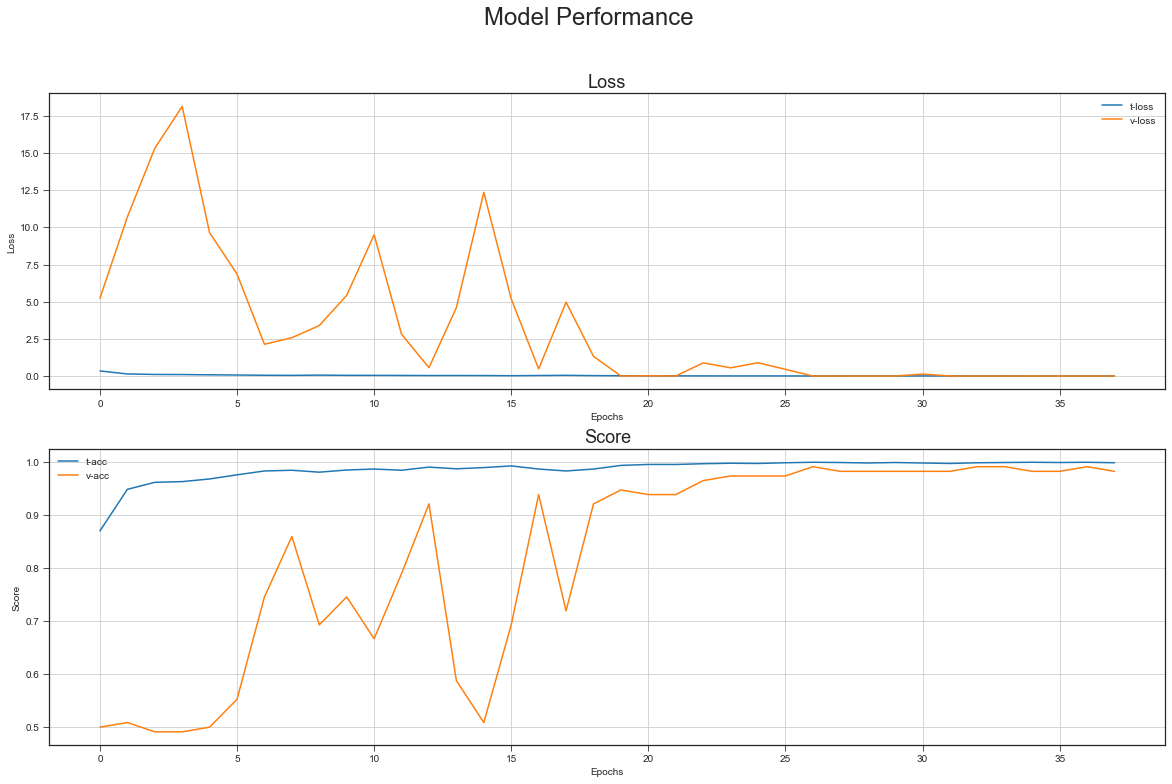

In [11]:
fig, ax = plt.subplots(2, 1, figsize=(20, 12))

fig.suptitle('Model Performance', fontsize=24) 

ax[0].plot(history.history['loss'], label='t-loss')
ax[0].plot(history.history['val_loss'], label='v-loss')
ax[0].set_title('Loss', fontsize=18)
ax[0].set_ylabel('Loss')

ax[1].plot(history.history['acc'], label='t-acc')
ax[1].plot(history.history['val_acc'], label='v-acc')
ax[1].set_title('Score', fontsize=18)
ax[1].set_ylabel('Score')

for i in range(2):
    ax[i].grid()
    ax[i].legend()
    ax[i].set_xlabel('Epochs')